# Logistic Regression Training on Encrypted Dataset

This notebook shows how to train a logistic regression model on encrypted data using stochastic gradient descent (SGD). During this process,
the training set remains encrypted at all times and the gradients and loss are encrypted, thus unaccessible by the server performing the training. 

The result of the encrypted training is a set of encrypted model weights that can only be decrypted by the training set secret-key owner. In Concrete ML the `fit` function encrypts the training data, trains the model producing encrypted weights and then decrypts the weights. The model can then be used in on clear data, or on new encrypted data.

Training on encrypted data is especially useful when multiple parties collaborate confidentially, meaning they provide encrypted shares of a training set. 

In this notebook, a Scikit-Learn model is first trained as the baseline. Next, a Concrete ML model is trained on encrypted data using Fully Homomorphic Encryption.

In [26]:
%matplotlib inline
# Import dataset libraries and util functions
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
from concrete.compiler import check_gpu_available
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn import datasets
from sklearn.linear_model import SGDClassifier as SklearnSGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

from concrete import fhe
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer
from concrete.ml.sklearn import SGDClassifier

use_gpu_if_available = False
device = "cuda" if use_gpu_if_available and check_gpu_available() else "cpu"


def plot_decision_boundary(
    X, y, clf=None, weights=None, bias=None, title="Decision Boundary", accuracy=None
):
    # Create a mesh to plot the decision boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    if clf is not None:
        # Predictions to get the decision boundary
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        learned_weights = (
            f"Learned weights: "
            f"{clf.coef_[0][0]:.3f}, "
            f"{clf.coef_[0][1]:.3f}, "
            f"{clf.intercept_.reshape((-1,))[0]:.3f}"
        )
    elif weights is not None and bias is not None:
        # Compute the linear model for the mesh grid
        linear_model = np.dot(np.c_[xx.ravel(), yy.ravel()], weights[0]) + bias[0]
        Z = np.round(1 / (1 + np.exp(-linear_model)))
        Z = Z.reshape(xx.shape)
        learned_weights = ""
    else:
        raise ValueError("Either 'clf' or both 'weights' and 'bias' must be provided.")

    # Define red and blue color map
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cm_bright)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=cm_bright)
    plt.title(f"{title} (Accuracy: {accuracy})\n {learned_weights}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Create a custom legend
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 0",
            markerfacecolor="#FF0000",
            markersize=10,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 1",
            markerfacecolor="#0000FF",
            markersize=10,
        ),
    ]
    plt.legend(handles=legend_elements, loc="upper right")

    plt.show()


# Load the Iris dataset
X_full, y_full = datasets.load_iris(return_X_y=True)
X_full = MinMaxScaler(feature_range=[-1, 1]).fit_transform(X_full)

# Select petal length and petal width for visualization
X = X_full[:, 2:4]  # Petal length and petal width

# Filter the dataset for binary classification (Versicolor and Virginica)
# These correspond to target labels 1 and 2 in the Iris dataset
binary_filter = (y_full == 1) | (y_full == 2)
X_binary = X[binary_filter]
X_full_binary = X_full[binary_filter]
y_binary = y_full[binary_filter] - 1

## Baseline Scikit-learn Training on Clear Data 

Training of the typical Scikit-Learn baseline. A Logistic Regression model is trained using SGD. 

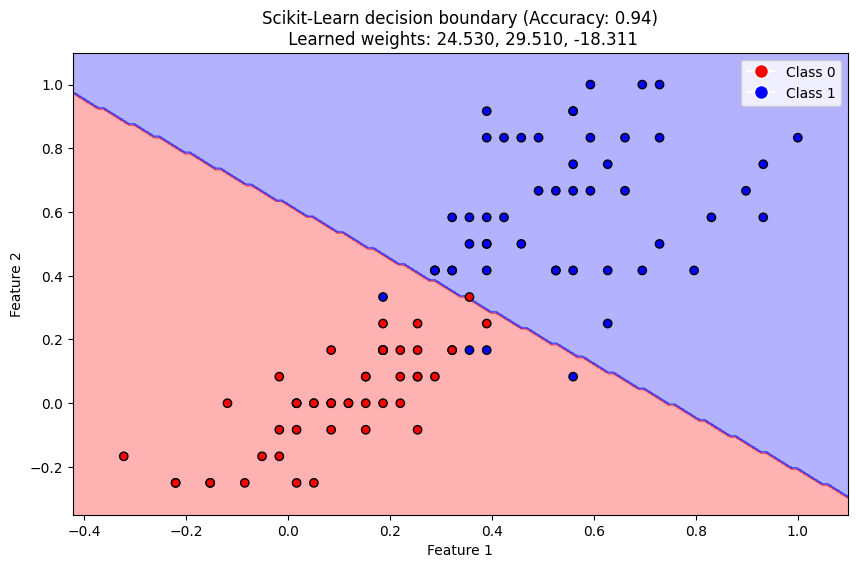

In [22]:
# Train an SGDClassifier on the binary dataset
N_ITERATIONS = 3
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

model_binary_sklearn = SklearnSGDClassifier(random_state=RANDOM_STATE, max_iter=N_ITERATIONS)

model_binary_sklearn.fit(X_binary, y_binary)

y_pred_binary_sklearn = model_binary_sklearn.predict(X_binary)

accuracy_binary_sklearn = accuracy_score(y_binary, y_pred_binary_sklearn)

plot_decision_boundary(
    X_binary,
    y_binary,
    clf=model_binary_sklearn,
    accuracy=accuracy_binary_sklearn,
    title="Scikit-Learn decision boundary",
)

In [23]:
class Client:
    def __init__(self):
        self.data = {}

    def __preprocess_data(self, data):
        return data
    
    def upload_data(self, condition, csv_path):
        data = self.__preprocess_data(pd.read_csv(csv_path))
        self.data[condition] = data

    def send_encrypted_data(self, condition):
        return self.data[condition]


In [24]:
class Server:
    def __init__(self):
        self.models = {}
    
    def recieve_encrypted_data(self, condition, data):
        x = data.iloc[:, :-1].copy()
        y = data.iloc[:, -1].copy().squeeze()
        
        # Step 2: Encode categorical features in x
        for column in x.select_dtypes(include=['object']).columns:
            x[column] = LabelEncoder().fit_transform(x[column])
        
        # Step 3: Encode target variable y if categorical
        if y.dtype == 'object':
            y = LabelEncoder().fit_transform(y)
        x_scaled = MinMaxScaler(feature_range=[-1, 1]).fit_transform(x)
        #eventually make this check firebase
        if condition not in self.models:
            parameters_range = (-1, 1)
            model = SGDClassifier(
                random_state=42,  # Or any fixed seed
                max_iter=5,  # Based on the notebook's parameter
                fit_encrypted=True,
                parameters_range=parameters_range,
                verbose=True
            )
            model.fit(x_scaled, y.squeeze(), fhe="execute", device="cpu")
            
        
    def send_model(self, condition):
        return self.models[condition]


## Training on Encrypted Data with Concrete ML

Training over encrypted data in FHE using SGD. Compared to the equivalent scikit-learn class, two new parameters need to be set: `fit_encrypted=True` and `parameters_range`. 

In [25]:
if __name__ == "__main__":
    c1 = Client() 
    c1.upload_data("heart disease", "../data/heart_data_1.csv")
    s = Server()
    data = c1.send_encrypted_data("heart disease")
    s.recieve_encrypted_data("heart disease", data)

NameError: name 'pd' is not defined

Compiling training circuit on device 'cpu'...
Compilation took 2.2184 seconds.
Key Generation...
Key generation took 7.1215 seconds.
Training on encrypted data...
Iteration 0 took 4.90 seconds.
Iteration 1 took 3.31 seconds.
Iteration 2 took 3.22 seconds.


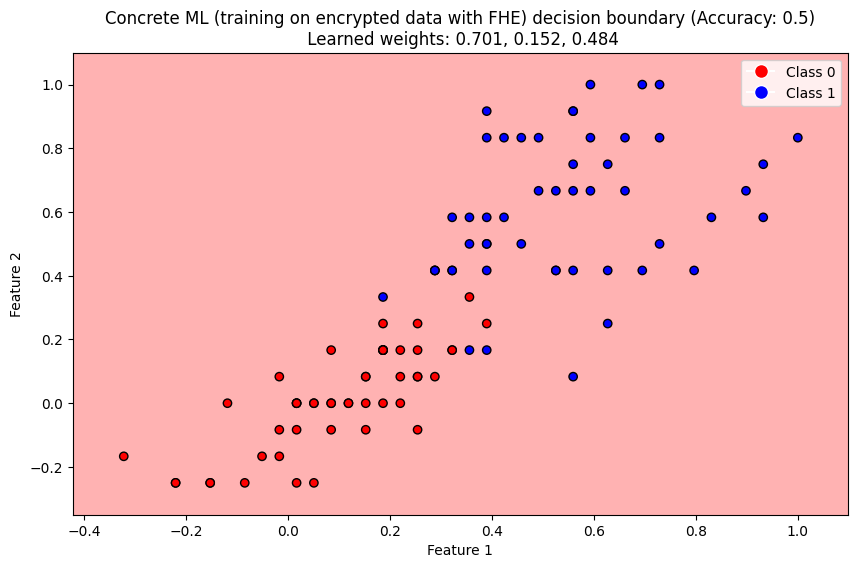

Iteration 4 took 2.19 seconds.


Iteration 5 took 2.50 seconds.


Iteration 6 took 2.28 seconds.


Iteration 7 took 2.46 seconds.


Iteration 8 took 2.23 seconds.


Iteration 9 took 3.14 seconds.


Iteration 10 took 2.41 seconds.


Iteration 11 took 2.20 seconds.


Iteration 12 took 2.19 seconds.


Iteration 13 took 2.19 seconds.


Iteration 14 took 2.33 seconds.


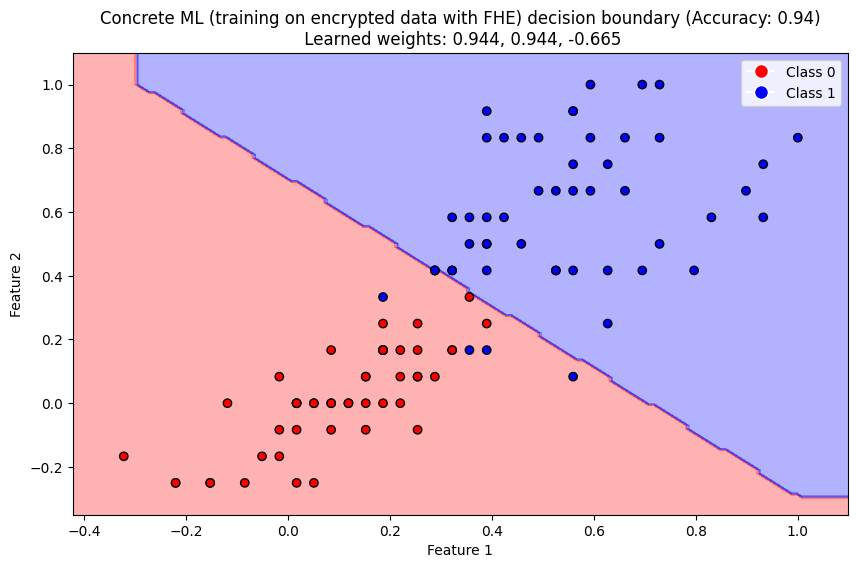

In [4]:
parameters_range = (-1.0, 1.0)

model_binary_fhe = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
    verbose=True,
)

# Fit on encrypted data
model_binary_fhe.fit(X_binary, y_binary, fhe="execute", device=device)

# The weights are decrypted at the end of the `fit` call. Use the clear weights here
# to evaluate accuracy on clear data
y_pred_binary = model_binary_fhe.predict(X_binary)

model_binary_fhe.compile(X_binary)

# Evaluate the decrypted weights on encrypted data
y_pred_binary_fhe = model_binary_fhe.predict(X_binary, fhe="execute")

# Check that the same result is obtained when applying
# the decrypted model on clear data and on encrypted data
# Linear classifiers are 100% correct on encrypted data compared to execution on clear data
assert np.all(y_pred_binary == y_pred_binary_fhe)

accuracy_binary_fhe = accuracy_score(y_binary, y_pred_binary_fhe)

plot_decision_boundary(
    X_binary,
    y_binary,
    clf=model_binary_fhe,
    accuracy=accuracy_binary_fhe,
    title="Concrete ML (training on encrypted data with FHE) decision boundary",
)